Saving archive (5).zip to archive (5) (5).zip
✅ Files extracted to: /content/air_quality_dataset
📂 Files inside: ['AirQuality.csv']
✅ Dataset shape: (9357, 15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,NaN,NaN,NaN,1360.0,150.0,NaN,1046.0,166.0,1056.0,113.0,1692.0,1268.0,NaN,NaN,NaN
1,NaN,NaN,2.0,1292.0,112.0,NaN,955.0,103.0,1174.0,92.0,1559.0,972.0,NaN,NaN,NaN
2,NaN,NaN,NaN,1402.0,88.0,NaN,939.0,131.0,1140.0,114.0,1555.0,1074.0,NaN,NaN,NaN
3,NaN,NaN,NaN,1376.0,80.0,NaN,948.0,172.0,1092.0,122.0,1584.0,1203.0,NaN,NaN,NaN
4,NaN,NaN,NaN,1272.0,51.0,NaN,836.0,131.0,1205.0,116.0,1490.0,1110.0,NaN,NaN,NaN


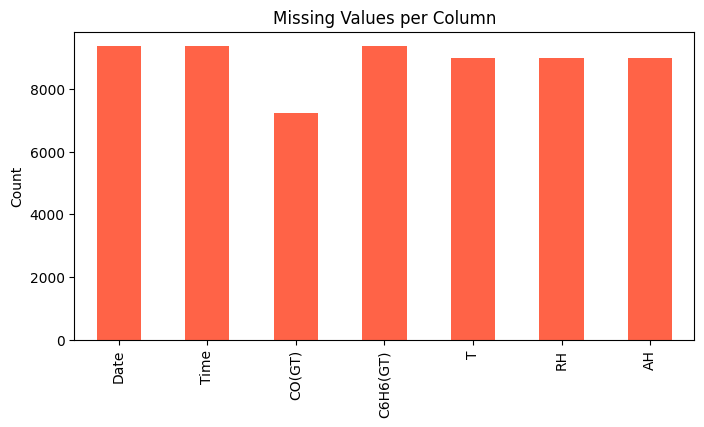

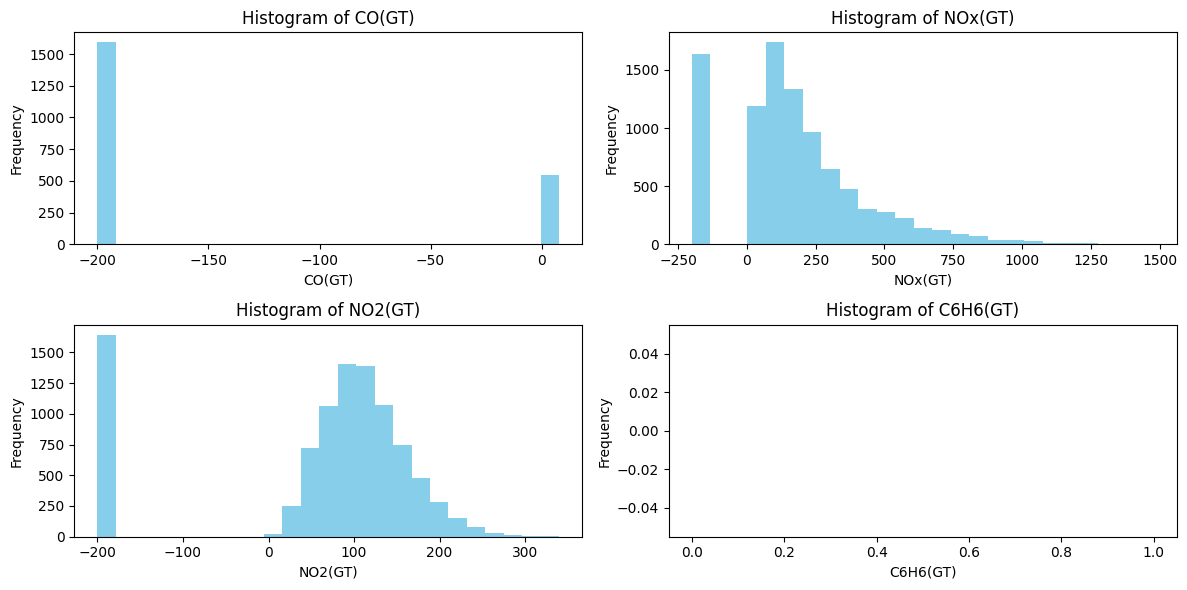

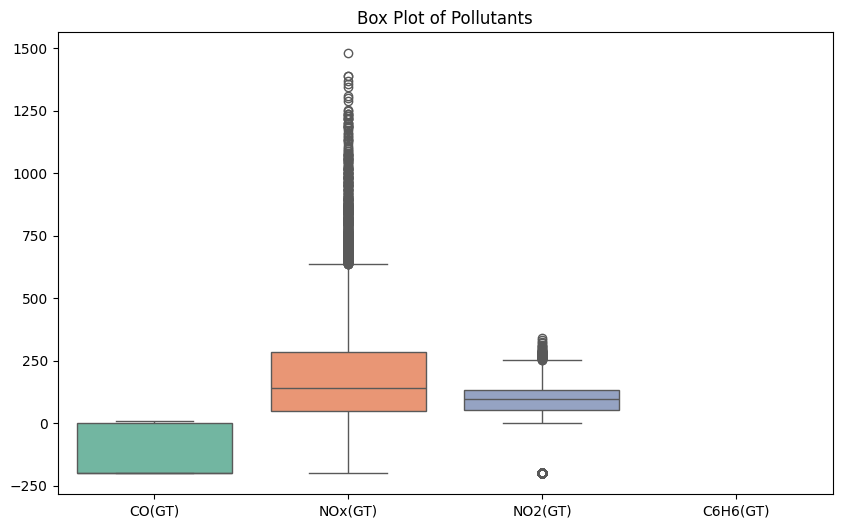

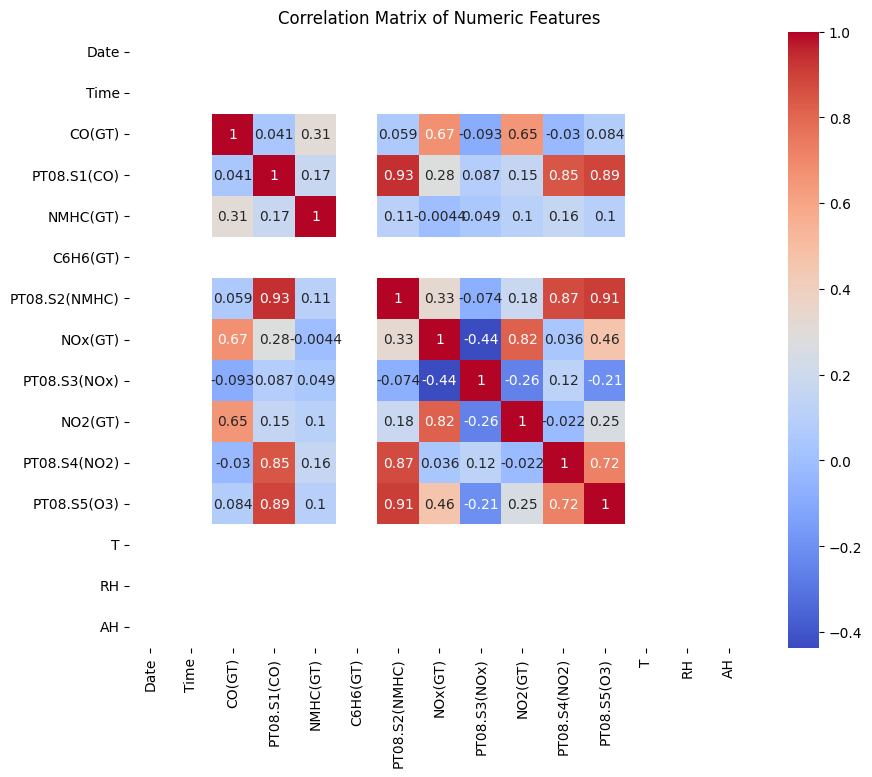

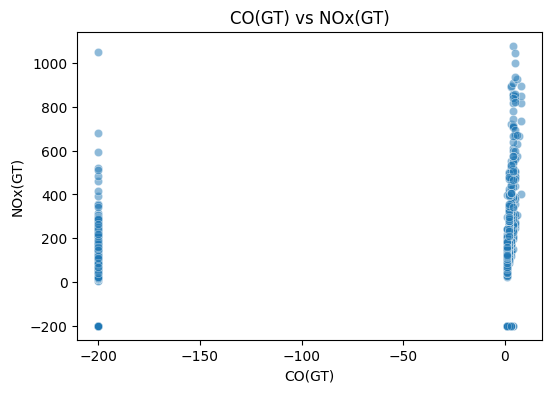

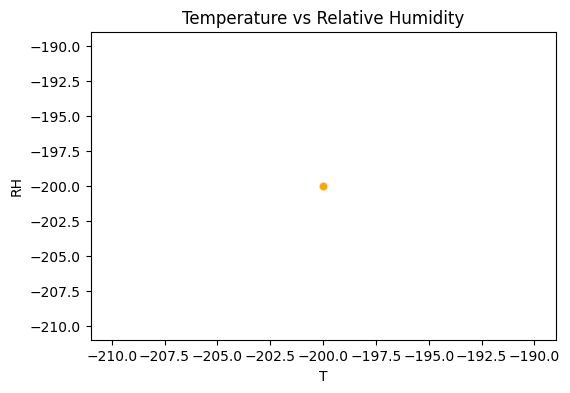

✅ Processed shape: (9357, 11)
✅ Feature type: float64
Train: (6553, 11) Val: (1400, 11) Test: (1404, 11)
Training with: {'units': 64, 'lr': 0.001}
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ValueError: Input contains NaN.

In [ ]:
# ============================================================
# IMPORTS
# ============================================================
import os
import zipfile
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    raise ImportError(
        "TensorFlow is required. Install with `pip install tensorflow`."
    ) from e

# ============================================================
# UPLOAD & EXTRACT ZIP
# ============================================================
from google.colab import files
uploaded = files.upload()  # Upload your zip file

zip_filename = list(uploaded.keys())[0]
extract_dir = "/content/air_quality_dataset"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Files extracted to:", extract_dir)
print("📂 Files inside:", os.listdir(extract_dir))

# ============================================================
# READ CSV
# ============================================================
csv_files = [f for f in os.listdir(extract_dir) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(extract_dir, csv_files[0]), sep=';', encoding='latin1')

# Drop fully empty & unnamed columns
df = df.dropna(axis=1, how='all')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Convert numeric columns to float
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where all values are NaN
df.dropna(how='all', inplace=True)
df.reset_index(drop=True, inplace=True)

print("✅ Dataset shape:", df.shape)
display(df.head())

# ============================================================
# EDA & VISUALIZATIONS (1-5)
# ============================================================

# 1. Missing Values Bar Chart
plt.figure(figsize=(8,4))
miss = df.isnull().sum()
miss[miss > 0].plot(kind='bar', color='tomato')
plt.title("Missing Values per Column")
plt.ylabel("Count")
plt.show()

# 2. Histogram of Key Pollutants
pollutants = ['CO(GT)','NOx(GT)','NO2(GT)','C6H6(GT)']
pollutants = [p for p in pollutants if p in df.columns]
plt.figure(figsize=(12,6))
for i, col in enumerate(pollutants):
    plt.subplot(2,2,i+1)
    plt.hist(df[col].dropna(), bins=25, color='skyblue')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 3. Box Plot
plt.figure(figsize=(10,6))
sns.boxplot(data=df[pollutants], palette="Set2")
plt.title("Box Plot of Pollutants")
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# 5. Scatter Plots
if 'CO(GT)' in df.columns and 'NOx(GT)' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x='CO(GT)', y='NOx(GT)', alpha=0.5)
    plt.title("CO(GT) vs NOx(GT)")
    plt.show()

if 'T' in df.columns and 'RH' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x='T', y='RH', alpha=0.5, color='orange')
    plt.title("Temperature vs Relative Humidity")
    plt.show()

# ============================================================
# PREPROCESSING
# ============================================================
target = 'CO(GT)'
X = df.drop(columns=[target])
y = df[target].values

# Numeric & categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if X[col].notna().sum() > 0]
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_processed = preprocessor.fit_transform(X)
print("✅ Processed shape:", X_processed.shape)
print("✅ Feature type:", X_processed.dtype)

# ============================================================
# TRAIN / VALIDATION / TEST SPLIT
# ============================================================
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_processed, y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.176, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ============================================================
# BUILD MLP MODEL
# ============================================================
def build_mlp(input_dim, units=64, dropout_rate=0.2, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(units, activation='relu'),
        layers.Dense(units//2, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model

input_dim = X_train.shape[1]

# ============================================================
# HYPERPARAMETER SEARCH
# ============================================================
search_space = [
    {'units':64, 'lr':1e-3},
    {'units':128, 'lr':1e-3},
    {'units':64, 'lr':1e-4},
]

best_val_rmse = float('inf')
best_model = None
best_hist = None
best_params = None

for params in search_space:
    print("Training with:", params)
    model = build_mlp(input_dim, units=params['units'], lr=params['lr'])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0
    )
    val_preds = model.predict(X_val).flatten()
    val_rmse = math.sqrt(mean_squared_error(y_val, val_preds))
    print(f"Val RMSE: {val_rmse:.4f}")
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model = model
        best_hist = history
        best_params = params

print("✅ Best Parameters:", best_params)
print("📉 Best Validation RMSE:", best_val_rmse)

# ============================================================
# TEST EVALUATION
# ============================================================
test_preds = best_model.predict(X_test).flatten()
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2: {test_r2:.4f}")

# ============================================================
# SAVE MODEL & PIPELINE
# ============================================================
best_model.save("air_quality_mlp_model.h5")
joblib.dump(preprocessor, "air_quality_preprocessor.joblib")
print("✅ Model and preprocessing saved.")

# ============================================================
# TRAINING CURVES & PREDICTION VISUALS (6-11)
# ============================================================
hist = best_hist.history

# 6. Loss over epochs
plt.figure(figsize=(6,4))
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title("Loss (MSE) vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 7. MAE over epochs
plt.figure(figsize=(6,4))
plt.plot(hist['mae'], label='Train MAE')
plt.plot(hist['val_mae'], label='Val MAE')
plt.title("MAE vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

# 8. Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, test_preds, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title("Predicted vs Actual CO(GT)")
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.show()

# 9. Residual distribution
residuals = y_test - test_preds
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=25, color='gray')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# 10. Residuals vs Actual
plt.figure(figsize=(6,4))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.title("Residuals vs Actual CO(GT)")
plt.xlabel("Actual CO(GT)")
plt.ylabel("Residual")
plt.show()

# 11. Metrics summary
metrics_df = pd.DataFrame({
    "Metric": ["Test RMSE", "Test MAE", "Test R2"],
    "Value": [test_rmse, test_mae, test_r2]
})
display(metrics_df)
